In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/magnetic"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/magnetic


In [ ]:
import csv
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import pandas as pd
import random
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random
import math
from torch.nn.utils import weight_norm
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import matplotlib.pyplot as plt
import shutil
from ipywidgets import interact, fixed
from ipywidgets import widgets
from ipywidgets import interactive, widgets
from IPython.display import display
from ipywidgets import interactive, widgets, HBox, VBox

from datetime import datetime
import socket


In [ ]:
import h5py

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Using device: cpu


In [ ]:
root_directory = 'data/Oxford Inertial Odometry Dataset'
kind = 'handheld'
floor = 'data1'
#seq_num = 1
num_sequences = [7,3,5,5,4]
num_folders = 1 #data1-4 for training, 5 for testing
gt_type = 'vi'

In [ ]:
WINDOW_SIZE = 120
STRIDE = 0
BATCH_SIZE = 32

In [ ]:
folder_name = "data_hdf5"
folder_path = os.path.join(root_directory, folder_name)

In [ ]:
dataset_name = os.path.join(root_directory, folder_name, f'dataset_reframe_data1_{WINDOW_SIZE}.hdf5')

In [ ]:
with h5py.File(dataset_name, 'r') as f:
    # Load testing data
    test_data = torch.from_numpy(f['test_data'][:])
    test_labels = torch.from_numpy(f['test_labels'][:])

In [ ]:
print("Testing normalized data shape:", test_data.shape, test_labels.shape)

Testing normalized data shape: torch.Size([13978, 120, 3]) torch.Size([13978, 2])


# **Create Dataset and load model**

In [ ]:
class MagneticDataset(Dataset):
    def __init__(self, mag_data, positions):
        self.mag_data = torch.tensor(mag_data, dtype=torch.float32)
        self.positions = torch.tensor(positions, dtype=torch.float32)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.mag_data[idx], self.positions[idx]

In [ ]:
test_dataset = MagneticDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<ipython-input-32-aaf90b1e6f58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mag_data = torch.tensor(mag_data, dtype=torch.float32)
<ipython-input-32-aaf90b1e6f58>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.positions = torch.tensor(positions, dtype=torch.float32)


In [ ]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        return self.leaky_relu(out + residual)

class MagneticModel(nn.Module):
    def __init__(self, input_shape, nb_filters=128):
        super(MagneticModel, self).__init__()
        self.tcn = nn.Sequential(
            TCNBlock(input_shape[1], nb_filters, kernel_size=3, dilation=1),
            TCNBlock(nb_filters, nb_filters, kernel_size=3, dilation=2),
            TCNBlock(nb_filters, nb_filters, kernel_size=3, dilation=4),
            TCNBlock(nb_filters, nb_filters, kernel_size=3, dilation=8),
            TCNBlock(nb_filters, nb_filters, kernel_size=3, dilation=16),
            TCNBlock(nb_filters, nb_filters, kernel_size=3, dilation=32)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(nb_filters * input_shape[0], 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.1),
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(0.1),
            nn.Linear(4, 2)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, channels, sequence_length)
        x = self.tcn(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x


In [ ]:
model = MagneticModel(input_shape=(WINDOW_SIZE, 3))
model.to(device)
criterion = nn.L1Loss()


In [ ]:
def evaluate(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_mae_loss = test_loss / len(test_loader)
    print(f'Test MAE: {test_mae_loss:.4f}')
    return test_mae_loss, np.array(all_predictions), np.array(all_targets)


In [ ]:
model_save_path = "model_mae0.3000.pth"

In [ ]:
model.load_state_dict(torch.load(model_save_path,map_location=device)['model_state_dict'])


<All keys matched successfully>

In [ ]:
test_mae_loss, predictions, targets = evaluate(model, criterion, device, test_loader)

Test MAE: 0.3848


In [ ]:
predictions.shape

(13978, 2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(targets[:,1],targets[:,0], color = 'g', label = 'gt')
ax.plot(targets[0,1], targets[0,0], 'o', color='y', markersize=10, label=f'Start Point')
ax.plot(targets[-1,1], targets[-1,0], 's', color='y', markersize=10, label=f'End Point')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
pred = predictions[:,:]
gt = targets[:,:]

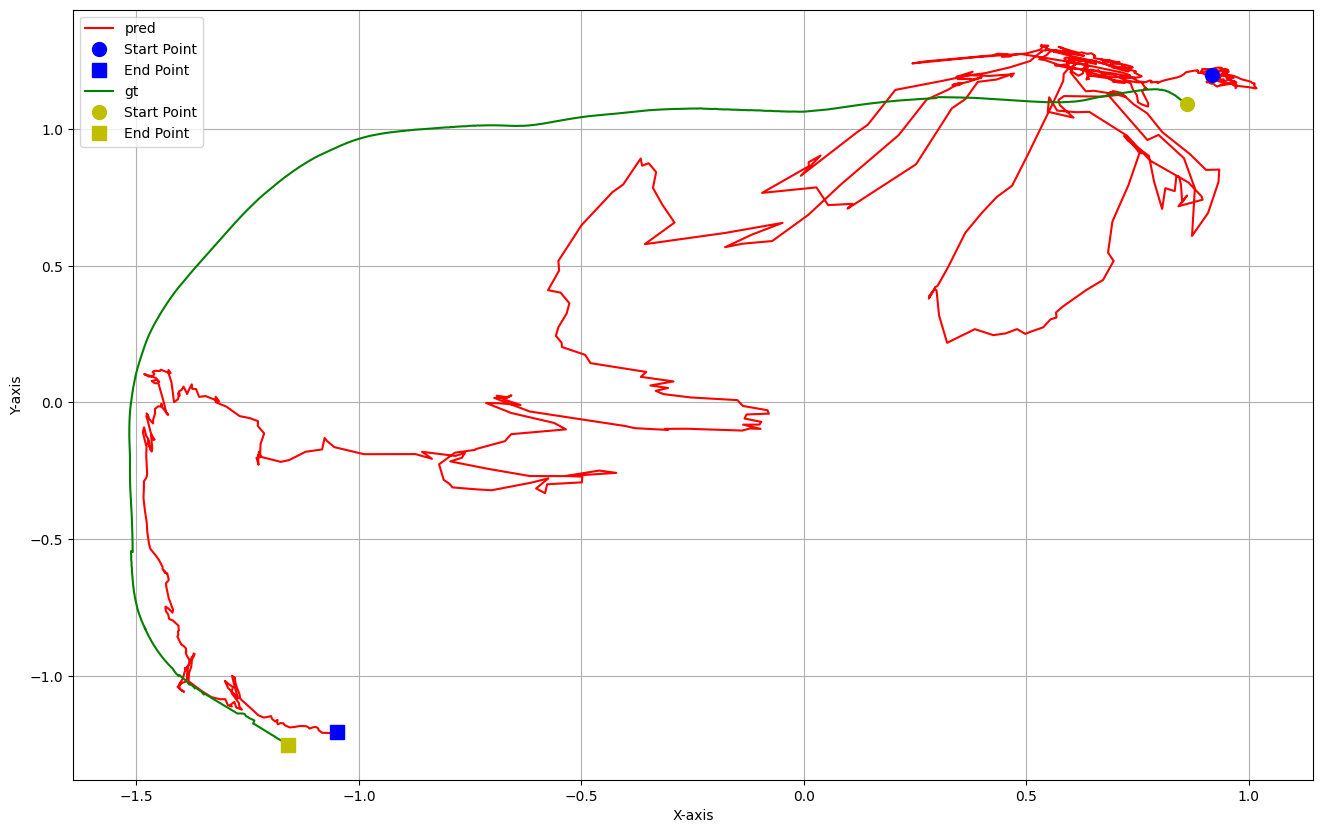

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 10))

# List of colors for different paths
#colors = plt.cm.jet(np.linspace(0, 1, len(paths)))
ax.plot(pred[:,1],pred[:,0], color = 'r', label = 'pred')
ax.plot(pred[0,1], pred[0,0], 'o', color='b', markersize=10, label=f'Start Point')
ax.plot(pred[-1,1], pred[-1,0], 's', color='b', markersize=10, label=f'End Point')

ax.plot(gt[:,1],gt[:,0], color = 'g', label = 'gt')
ax.plot(gt[0,1], gt[0,0], 'o', color='y', markersize=10, label=f'Start Point')
ax.plot(gt[-1,1], gt[-1,0], 's', color='y', markersize=10, label=f'End Point')


# Plot each path with a different color
# for idx, (path, color) in enumerate(zip(paths, colors)):
#     # if idx != 3:
#     #     continue
#     ax.plot(path['y'], path['x'], color=color, label=f'Path {idx + 1}')
#     # Highlight the start point
#     ax.plot(path['y'][0], path['x'][0], 'o', color=color, markersize=10, label=f'Start Point {idx + 1}')
#     # Highlight the end point
#     ax.plot(path['y'][-1], path['x'][-1], 's', color=color, markersize=10, label=f'End Point {idx + 1}')



# Add title and labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
!pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 57.6 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20727 sha256=df0590be254e92b964a047ab64011e9041575df740546cb1a70fb1c77ae15f58
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import mplcursors

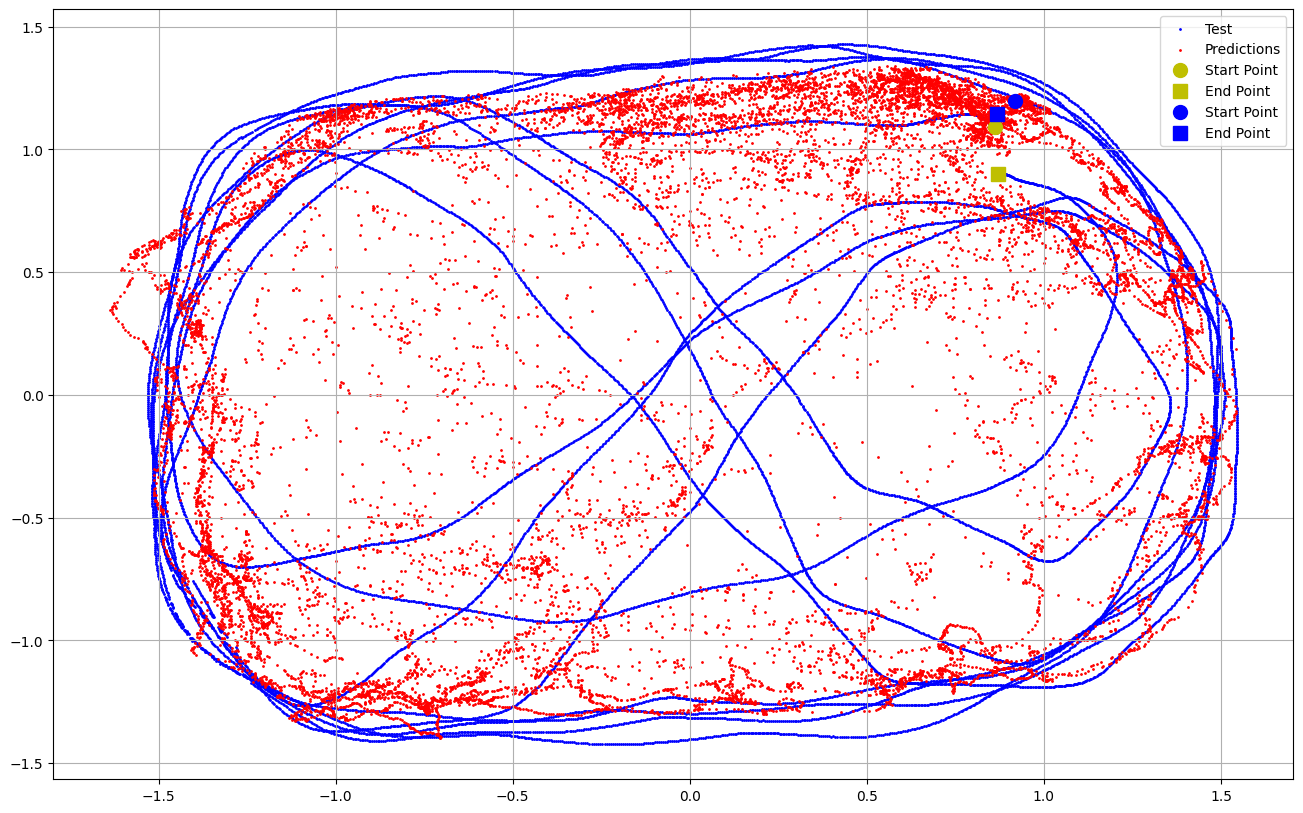

In [ ]:
def on_hover(sel):
    x, y, _, _ = sel.target
    print(f"Hovered over point: x={x:.2f}, y={y:.2f}")

fig, ax = plt.subplots(figsize=(16, 10))

#ax.invert_yaxis()
# Plot the points
x_gt = gt[:,0]
y_gt = gt[:,1]
x_pred = pred[:,0]
y_pred = pred[:,1]


# Scatter plots

scatter_gt = ax.scatter(y_gt, x_gt, s=1, c='b', label='Test')
scatter_pred = ax.scatter(y_pred, x_pred, s=1, c='r', label='Predictions')

# Add color bar
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=5, label='Test'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=5, label='Predictions')
]
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot


ax.plot(gt[0,1], gt[0,0], 'o', color='y', markersize=10, label=f'Start Point')
ax.plot(gt[-1,1], gt[-1,0], 's', color='y', markersize=10, label=f'End Point')
ax.plot(pred[0,1], pred[0,0], 'o', color='b', markersize=10, label=f'Start Point')
ax.plot(pred[-1,1], pred[-1,0], 's', color='b', markersize=10, label=f'End Point')
ax.legend()
ax.grid(True)

cursors_gt = mplcursors.cursor(scatter_gt)
cursors_gt.connect("add", on_hover)

cursors_pred = mplcursors.cursor(scatter_pred)
cursors_pred.connect("add", on_hover)

plt.show()